In [ ]:
#import libraries

In [7]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --------- ------------------------------ 2.1/8.9 MB 11.8 MB/s eta 0:00:01
   ----------------------- ---------------- 5.2/8.9 MB 13.9 MB/s eta 0:00:01
   ------------------------------------ --- 8.1/8.9 MB 14.0 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 13.8 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -

In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install boxsdk
pip install boxsdk --quiet


   ---------------------------------------- 0/2 [requests-toolbelt]
   ---------------------------------------- 0/2 [requests-toolbelt]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   -------------------- ------------------- 1/2 [boxsdk]
   ---------------------------------------- 2/2 [boxsdk]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pathlib
import re
from pathlib import Path
from tqdm.auto import tqdm
import torch.nn as nn


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split



In [ ]:
#load data from .csv files

In [6]:
data_dir = Path("C:/Users/13523/Desktop/IQ data/out1")
assert data_dir.exists(), f"Folder not found: {data_dir.resolve()}"

# Peek a few CSV names to confirm formatting
all_csvs = list(data_dir.rglob("*.csv"))
print(f"Found {len(all_csvs)} CSVs under {data_dir.resolve()}")
for p in all_csvs[:5]:
    print("example:", p.name)

# 1) strict pattern: class<digits>_sample<digits>.csv
pat_strict = re.compile(r"class(?P<cls>\d+)_sample(?P<idx>\d+)\.csv$", re.I)
# 2) looser pattern (allows extra stuff between tokens/suffixes)
pat_loose  = re.compile(r"class\s*(?P<cls>\d+).*?sample\s*(?P<idx>\d+).*\.csv$", re.I)

rows = []
unmatched = 0
for p in all_csvs:
    name = p.name
    m = pat_strict.search(name) or pat_loose.search(name)
    # also try the full relative path (in case class/sample live in folders)
    if not m:
        m = pat_loose.search(p.as_posix())
    if not m:
        unmatched += 1
        continue
    rows.append({
        "class": int(m["cls"]),
        "sample": int(m["idx"]),
        "filename": name,
        "path": p.resolve().as_posix()
    })

if not rows:
    raise ValueError(
        "No files matched the expected pattern.\n"
        "→ Check your filenames. Expected like: class12_sample34.csv "
        "or paths containing .../class12/.../sample34.csv\n"
        f"Peek above shows examples; update the regex to match them."
    )

manifest = (pd.DataFrame(rows)
              .sort_values(["class", "sample"])
              .reset_index(drop=True))
print(f"Indexed {len(manifest)} CSVs across {manifest['class'].nunique()} classes.")
print(manifest[["class","sample","filename"]].head(10))


Found 15740 CSVs under C:\Users\13523\Desktop\IQ data\out1
example: class100_sample1.csv
example: class100_sample10.csv
example: class100_sample100.csv
example: class100_sample101.csv
example: class100_sample102.csv
Indexed 15740 CSVs across 144 classes.
   class  sample             filename
0      1       1   class1_sample1.csv
1      1       2   class1_sample2.csv
2      1       3   class1_sample3.csv
3      1       4   class1_sample4.csv
4      1       5   class1_sample5.csv
5      1       6   class1_sample6.csv
6      1       7   class1_sample7.csv
7      1       8   class1_sample8.csv
8      1       9   class1_sample9.csv
9      1      10  class1_sample10.csv


In [ ]:
#validate dataset

In [3]:
#validate expected size of 110 samples per class
EXPECTED = 110

iq_data = manifest.groupby("class")["sample"].nunique().rename("count")
print(counts)

# classes with wrong counts
bad = counts[counts != EXPECTED]
if not bad.empty:
    print("\nClasses with missing/excess samples:")
    for cls, cnt in bad.items():
        have = set(manifest.loc[manifest["class"]==cls, "sample"])
        need = set(range(1, EXPECTED+1))
        missing = sorted(need - have)
        extras  = sorted(have - need)
        print(f"  class {cls}: {cnt}/{EXPECTED} "
              f"{'(missing: ' + str(missing[:10]) + (' ...' if len(missing)>10 else '') + ')' if missing else ''}"
              f"{'(extras: '  + str(extras[:10])  + (' ...' if len(extras)>10  else '') + ')' if extras  else ''}")

#creates dict for data
iq = {}
for (cls, idx), grp in manifest.set_index(["class","sample"]).groupby(level=[0,1]):
    iq.setdefault(cls, {})[idx] = pd.read_csv(grp["path"].iloc[0])

# example access:
# df = iq[10][104]


NameError: name 'manifest' is not defined

In [ ]:
#example size check

In [ ]:
arr = load_iq_csv("IQ data/class1_sample1.csv")
print(arr.shape)   # (N, 2)
print(arr[:5])     # first 5 rows of [I, Q]


In [ ]:
#data preparation

In [8]:
#one time conversion from csv files to .npy
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm

TARGET_LEN = 1000
out_dir = Path("C:/Users/13523/Desktop/IQ_npy"); #out path
out_dir.mkdir(parents=True, exist_ok=True)

def load_iq_csv(path: str) -> np.ndarray:
    # your normalized loader
    df = pd.read_csv(path, header=None)
    x = df.iloc[:, :2].to_numpy(dtype=np.float32) #normalization
    x -= x.mean(axis=0, keepdims=True)
    x /= (x.std(axis=0, keepdims=True) + 1e-8)
    return x

def pad_or_crop_to_len(x: np.ndarray, L: int) -> np.ndarray:
    T = x.shape[0]
    if T == L: return x
    if T > L:
        s = (T - L)//2
        return x[s:s+L]
    out = np.zeros((L, 2), dtype=np.float32)
    out[:T] = x
    return out

# rename 'class' → 'cls' so itertuples gives valid identifiers
mf = manifest.rename(columns={'class': 'cls'})

rows_npy = []
for cls, sample, filename, path in tqdm(
        mf[['cls','sample','filename','path']].itertuples(index=False, name=None),
        total=len(mf), desc="Converting CSV→NPY"):
    x = load_iq_csv(path)                       # (T,2) normalized
    x = pad_or_crop_to_len(x, TARGET_LEN)       # (1000,2) float32
    out_path = (out_dir / filename).with_suffix(".npy")
    np.save(out_path, x.astype(np.float32))
    rows_npy.append((cls, sample, out_path.as_posix()))

manifest_npy = (pd.DataFrame(rows_npy, columns=["class","sample","path"]) 
                  .sort_values(["class","sample"])
                  .reset_index(drop=True))


Converting CSV→NPY:   0%|          | 0/15740 [00:00<?, ?it/s]

In [ ]:
#write manifest from .NPY files

In [ ]:
#after writing manifest from .npy files create train, test, and vailidation datasets

In [5]:
# ---------------- labels + splits ----------------
classes = sorted(manifest_npy["class"].unique())
cls2id  = {c: i for i, c in enumerate(classes)}
manifest_npy = manifest_npy.copy()
manifest_npy["label"] = manifest_npy["class"].map(cls2id).astype(int)

# sanity: each class should have 110 samples (or whatever you expect)
print(manifest_npy.groupby("class")["sample"].nunique().sort_index())

SEED = 42
train_df, test_df = train_test_split(
    manifest_npy, test_size=0.15, stratify=manifest_npy["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df["label"], random_state=SEED
)

# ---------------- Dataset (npy already normalized: (1000,2)) ----------------
class IQNPYDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.paths  = df["path"].tolist()
        self.labels = df["label"].astype(int).tolist()
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        x = np.load(self.paths[i]).astype(np.float32)   # (1000,2)
        x = torch.from_numpy(x).permute(1, 0).contiguous()  # (2,1000)
        y = torch.tensor(self.labels[i], dtype=torch.long)
        return x, y

# ---------------- DataLoaders ----------------
is_windows = (os.name == "nt")
num_workers = 0 if is_windows else max(1, os.cpu_count() // 2)

train_loader = DataLoader(IQNPYDataset(train_df), batch_size=256, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(IQNPYDataset(val_df),   batch_size=512, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(IQNPYDataset(test_df),  batch_size=512, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# ---------------- sanity check ----------------
xb, yb = next(iter(train_loader))
print("xb:", tuple(xb.shape), xb.dtype)                  # (B,2,1000), float32
print("yb:", tuple(yb.shape), yb.dtype)                  # (B,), int64
print(f"Classes: {len(classes)} | Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}")

class
1      110
10     110
11     110
12     110
13     110
      ... 
225    110
226    110
227    110
228    110
229    110
Name: sample, Length: 144, dtype: int64
xb: (256, 2, 1000) torch.float32
yb: (256,) torch.int64
Classes: 144 | Train/Val/Test: 11372/2007/2361


In [6]:
class RFF_Classifier(nn.Module):
    """
    1D-CNN for I/Q (2 channels), T=1000:
      Conv(2→64,k7,d1)→BN→ReLU
      Conv(64→128,k5,d2)→BN→ReLU
      MaxPool(2)
      Conv(128→256,k3,d4)→BN→ReLU
      GAP → Dropout(0.3) → FC(256→C)
    """
    def __init__(self, n_classes: int, in_ch: int = 2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, 64, kernel_size=7, dilation=1, padding=3, bias=False)
        self.bn1   = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, dilation=2, padding=4, bias=False)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool  = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, dilation=4, padding=4, bias=False)
        self.bn3   = nn.BatchNorm1d(256)
        self.gap   = nn.AdaptiveAvgPool1d(1)
        self.drop  = nn.Dropout(p=0.3)
        self.fc    = nn.Linear(256, n_classes)
        # init
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        # accept (B,1000,2) or (B,2,1000)
        if x.dim()==3 and x.size(1)!=2 and x.size(2)==2:
            x = x.permute(0,2,1).contiguous()
        x = F.relu(self.bn1(self.conv1(x)))   # (B,64,1000)
        x = F.relu(self.bn2(self.conv2(x)))   # (B,128,1000)
        x = self.pool(x)                      # (B,128,500)
        x = F.relu(self.bn3(self.conv3(x)))   # (B,256,500)
        x = self.gap(x).squeeze(-1)           # (B,256)
        x = self.drop(x)
        return self.fc(x)                     # (B,C) logits

# --- Train / Eval ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = int(len(np.unique(train_df["label"])))

model = RFF_Classifier(n_classes=n_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()

def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

@torch.no_grad()
def run_epoch(loader, model, criterion):
    model.eval()
    loss_sum = acc_sum = n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        b = y.size(0)
        loss_sum += loss.item() * b
        acc_sum  += accuracy(logits, y) * b
        n += b
    return loss_sum / n, acc_sum / n

def train(num_epochs=15):
    for epoch in range(1, num_epochs+1):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        val_loss, val_acc = run_epoch(val_loader, model, criterion)
        print(f"Epoch {epoch:02d} | val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")
    test_loss, test_acc = run_epoch(test_loader, model, criterion)
    print(f"TEST | loss={test_loss:.4f} | acc={test_acc:.3f}")

# --- sanity check then train ---
xb, yb = next(iter(train_loader))
print("xb:", tuple(xb.shape), xb.dtype)  # (B,2,1000)
print("yb:", tuple(yb.shape), yb.dtype)  # (B,), int64
# train()

xb: (256, 2, 1000) torch.float32
yb: (256,) torch.int64


In [ ]:
#Call train function

In [7]:
train()

Epoch 01 | val_loss=4.9748 | val_acc=0.008
Epoch 02 | val_loss=4.9683 | val_acc=0.008
Epoch 03 | val_loss=4.9681 | val_acc=0.006
Epoch 04 | val_loss=4.9689 | val_acc=0.005
Epoch 05 | val_loss=4.9698 | val_acc=0.008
Epoch 06 | val_loss=4.9710 | val_acc=0.009
Epoch 07 | val_loss=4.9717 | val_acc=0.006
Epoch 08 | val_loss=4.9701 | val_acc=0.006


KeyboardInterrupt: 

In [ ]:
#PLOTTING-------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#plotting function definitions
def plot_class_overlays(manifest: pd.DataFrame, cls: int, n=5, decim=1, normalize=True):
    """
    Overlay I & Q waveforms and a constellation for `n` random samples of a single class.
    decim: plot every decim-th point to reduce clutter.
    """
    rows = manifest[manifest["class"] == cls]
    if rows.empty:
        raise ValueError(f"No files for class {cls}")
    pick = rows.sample(min(n, len(rows)), random_state=0)

    plt.figure(); plt.title(f"I waveforms — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])  # (T,2)
        x = sig[::decim, 0]
        if normalize: x = (x - x.mean()) / (x.std() + 1e-8)
        plt.plot(x, alpha=0.7)

    plt.figure(); plt.title(f"Q waveforms — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])
        x = sig[::decim, 1]
        if normalize: x = (x - x.mean()) / (x.std() + 1e-8)
        plt.plot(x, alpha=0.7)

    plt.figure(); plt.title(f"Constellation — class {cls}")
    for _, r in pick.iterrows():
        sig = load_iq_csv(r["path"])
        I, Q = sig[::decim, 0], sig[::decim, 1]
        if normalize:
            I = (I - I.mean()) / (I.std() + 1e-8)
            Q = (Q - Q.mean()) / (Q.std() + 1e-8)
        plt.plot(I, Q, ".", ms=2, alpha=0.5)
    plt.axis("equal")
    plt.show()


def plot_constellation_across_classes(manifest: pd.DataFrame, classes, per_class=3, decim=2, normalize=True):
    """
    One constellation plot comparing multiple classes.
    `per_class`: number of samples per class to plot.
    """
    plt.figure()
    for cls in classes:
        rows = manifest[manifest["class"] == cls]
        if rows.empty:
            continue
        pick = rows.sample(min(per_class, len(rows)), random_state=0)
        I_all, Q_all = [], []
        for _, r in pick.iterrows():
            sig = load_iq_csv(r["path"])
            I, Q = sig[::decim, 0], sig[::decim, 1]
            if normalize:
                I = (I - I.mean()) / (I.std() + 1e-8)
                Q = (Q - Q.mean()) / (Q.std() + 1e-8)
            I_all.append(I); Q_all.append(Q)
        if I_all:
            I_cat = np.concatenate(I_all); Q_cat = np.concatenate(Q_all)
            plt.plot(I_cat, Q_cat, ".", ms=2, alpha=0.4, label=f"class {cls}")
    plt.axis("equal"); plt.legend(); plt.title("Constellation comparison across classes")
    plt.show()

In [ ]:
# ------------ Data Visualization

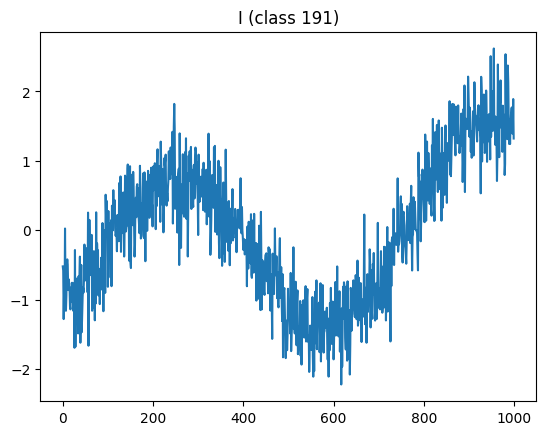

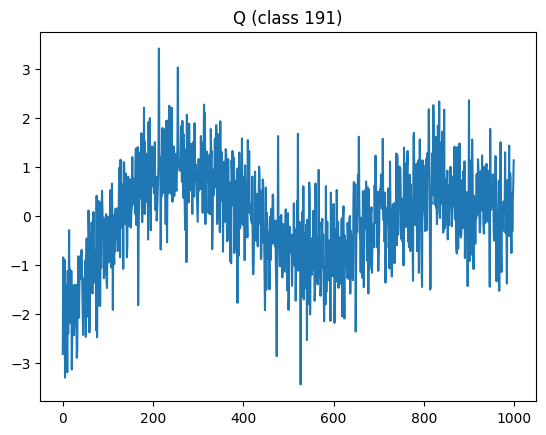

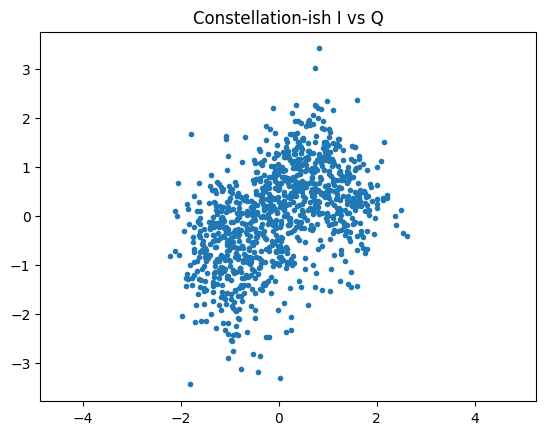

In [22]:
#visualize single .csv
row = train_df.sample(1, random_state=0).iloc[0]
sig = load_iq_csv(row["path"])  # (T,2)
plt.figure(); plt.plot(sig[:,0]); plt.title(f"I (class {row['class']})")
plt.figure(); plt.plot(sig[:,1]); plt.title(f"Q (class {row['class']})")
plt.figure(); plt.plot(sig[:,0], sig[:,1], "."); plt.title("Constellation-ish I vs Q"); plt.axis("equal")
plt.show()

In [ ]:
# -------- Visualize single class and class comparison

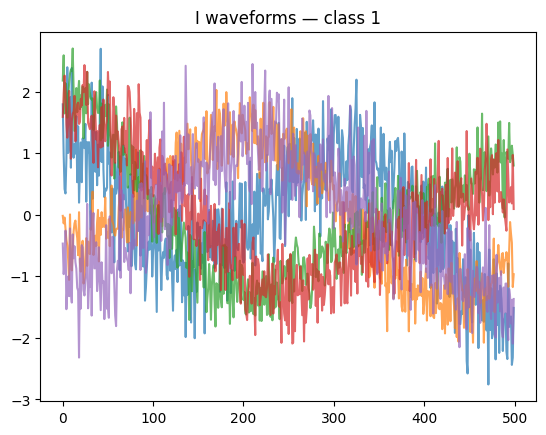

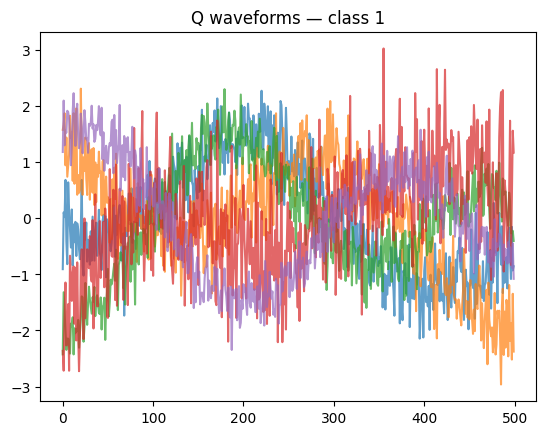

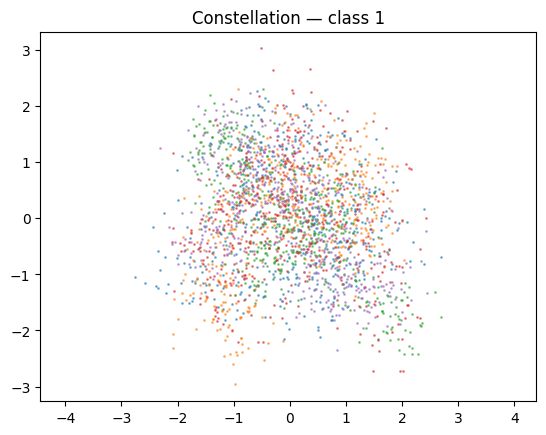

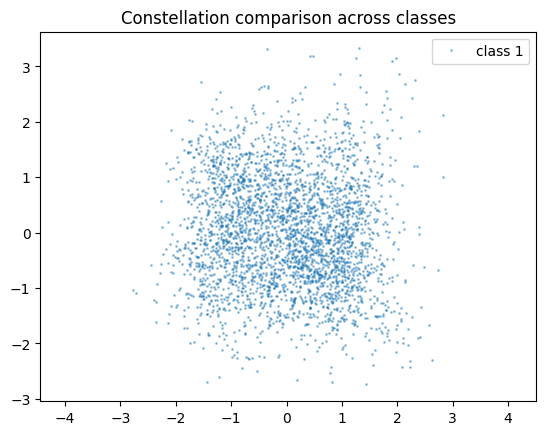

In [27]:
# Same class overlays (e.g., class 1, 6 samples)
plot_class_overlays(manifest, cls=1, n=5, decim=2)

# Compare classes 1, 5, 10 with 3 samples each
plot_constellation_across_classes(manifest, classes=[1,2,3], per_class=10, decim=3)
